# Homework 1

**Name**: **[Arvin Hosseini]**

**UID**: **[205594617]**

In [ ]:
# Download a processed version of the data
!wget https://web.cs.ucla.edu/~zshi/files/CS146/mushroom.txt

--2022-10-26 06:23:26--  https://web.cs.ucla.edu/~zshi/files/CS146/mushroom.txt
Resolving web.cs.ucla.edu (web.cs.ucla.edu)... 131.179.128.29
Connecting to web.cs.ucla.edu (web.cs.ucla.edu)|131.179.128.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1264848 (1.2M) [text/plain]
Saving to: ‘mushroom.txt.3’

mushroom.txt.3      100%[===================>]   1.21M  3.03MB/s    in 0.4s    

2022-10-26 06:23:26 (3.03 MB/s) - ‘mushroom.txt.3’ saved [1264848/1264848]



In [ ]:
# Use only the provided packages
import sys
import math
import csv
import pandas
import os
import random
import numpy as np
from collections import Counter
from dataclasses import dataclass

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

mpl.lines.width = 2
mpl.axes.labelsize = 14

In [ ]:
class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y

In [ ]:
class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        
        # set self.probabilities_ according to the training set

        self.probabilities_ = dict()
        #count the number of times y is 1 and divide by nunber of y's to set average for prob [1]
        self.probabilities_[1] = np.sum(y) / y.shape[0]
        #subtract self.probabilities_[1] from 1 in order to find the probablity of y being 0
        self.probabilities_[0] = 1- self.probabilities_[1]
       

        

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        # predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)

        #set y to an empty array the same size as the amount of mushrooms
        y = np.empty((X.shape[0]))
        for i in range(X.shape[0]): # for each example set the ith value of y to either 0 or 1 based on the proabalities found earlier
          curr_y = np.random.choice([0, 1], p=[self.probabilities_[0], self.probabilities_[1]])
          y[i] = curr_y


        return y


In [ ]:
def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,20))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend()

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

    return data, bins, align, labels

In [ ]:
def error(clf, X, y, ntrials=1, test_size=0.0) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

   
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use StratifiedShuffleSplit (be careful of the parameters)
    
    #use StartifiedShuffleSplit from sklearn with random state of 0
    sss = StratifiedShuffleSplit(n_splits = ntrials, test_size = test_size, random_state=0)

    train_error = 0
    test_error = 0
    f1_score = 0

    train_error_total = 0
    test_error_total = 0
    f1_score_total = 0

    for train_index, test_index in sss.split(X,y):  
      #create training and test set
      X_train, X_test = X[train_index], X[test_index] 
      y_train, y_test = y[train_index], y[test_index]
      #fit the training data set
      clf.fit(X_train, y_train)
      y_train_pred = clf.predict(X_train)        # take the classifier and run it on the training data
      y_test_pred = clf.predict(X_test)          # take the classifier and run it on the test data
      #sum the train and test errors along with all the f1 scores
      train_error_total += 1 - metrics.accuracy_score(y_train, y_train_pred, normalize=True)
      test_error_total += 1 - metrics.accuracy_score(y_test, y_test_pred, normalize=True)
      f1_score_total += metrics.f1_score(y_test, y_test_pred, average = 'micro')

    #find the averages
    train_error = train_error_total / ntrials
    test_error = test_error_total / ntrials
    f1_score = f1_score_total / ntrials



    

    return train_error, test_error, f1_score


In [ ]:
# Load the Mushroom dataset

@dataclass
class Dataset:
    """Class for the dataset."""
    X: np.array
    y: np.array
    Xnames: list
    yname: str

def load_data(data_file='mushroom.txt'):
    """Load data and map strings to numbers."""
    data = pandas.read_csv(data_file).to_numpy()
    n = data.shape[0]
    d = data.shape[1] - 1
    # Map strings to numbers
    X = np.zeros((n, d))
    for i in range(d):
        mapping = {name: j for j, name in enumerate(sorted(set(data[:, i+1])))}
        for j in range(n):
            X[j, i] = mapping[data[j, i+1]]
    mapping = {'EDIBLE': 1, 'POISONOUS': 0}
    y = np.zeros(n, dtype=np.int32)
    for j in range(n):
        y[j] = mapping[data[j, 0]]
    #0 'cap-shape', 
    #1 'cap-surface', 
    #2 'cap-color', 
    #3 'bruises', 
    #4 'odor',      
    #5 'gill-attachment', 
    #6 'gill-spacing', 
    #7 'gill-size', 
    #8 'gill-color',
    #9 'stalk-shape', 
    #10 'stalk-root', 
    #11 'stalk-surface-above-ring', 
    #12 'stalk-surface-below-ring',
    #13 'stalk-color-above-ring',
    #14 'stalk-color-below-ring',
    #15 'veil-type',
    #16 'veil-color',
    #17 'ring-number',
    #18 'ring-type',
    #19 'spore-print-color',
    #20 'population',
    #21 'habitat',        
    Xnames = [
        'cap-shape', 
        'cap-surface', 
        'cap-color', 
        'bruises', 
        'odor',
        'gill-attachment', 
        'gill-spacing', 
        'gill-size', 
        'gill-color',
        'stalk-shape', 
        'stalk-root', 
        'stalk-surface-above-ring', 
        'stalk-surface-below-ring',
        'stalk-color-above-ring',
        'stalk-color-below-ring',
        'veil-type',
        'veil-color',
        'ring-number',
        'ring-type',
        'spore-print-color',
        'population',
        'habitat',
    ]
    # We only use these 6 features
    features = [0, 2, 8, 10, 15, 17]
    X = np.take(X, features, axis=-1)
    Xnames = [Xnames[i] for i in features]
    return Dataset(X=X, y=y, Xnames=Xnames, yname='edible')

data = load_data()

X = data.X; Xnames = data.Xnames
y = data.y; yname = data.yname
n,d = X.shape  # n = number of examples, d =  number of features


# Shuffle the data for cross-validation
import random
idx = list(range(n))
random.seed(0)
random.shuffle(idx)
X = np.take(X, idx, axis=0)
y = np.take(y, idx, axis=0)

Plotting...


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


<Figure size 432x288 with 0 Axes>

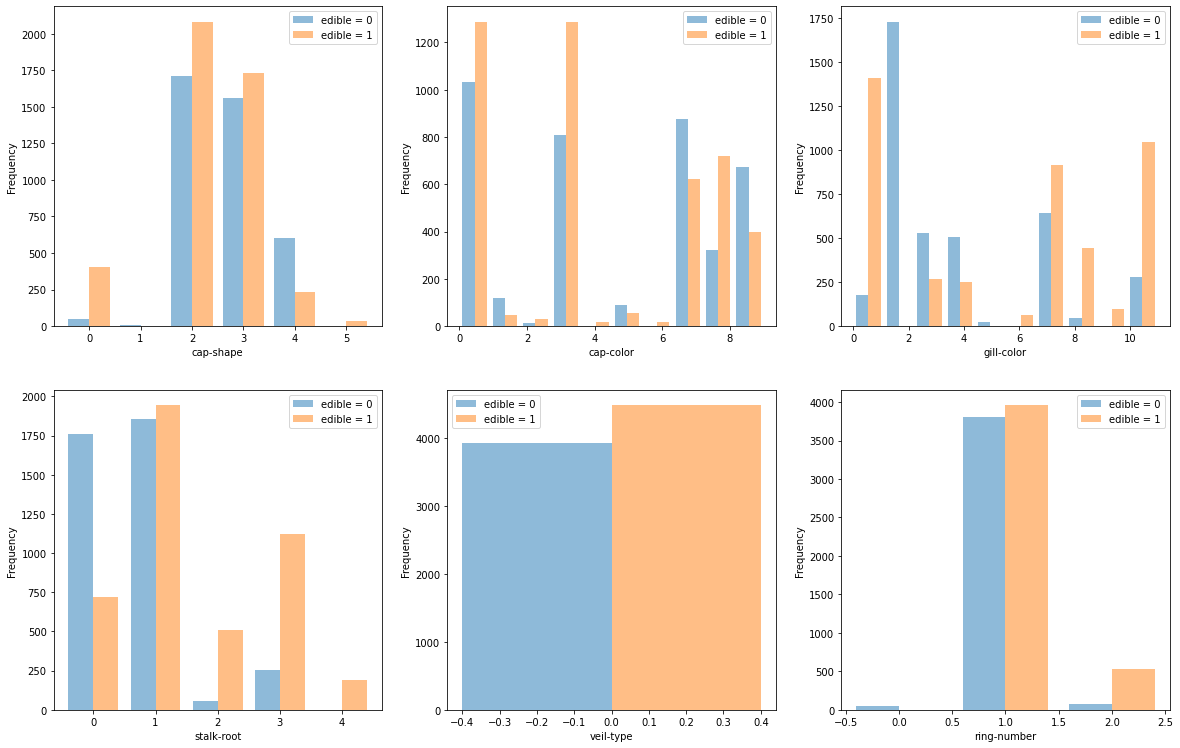

In [ ]:
plt.figure()
# Plot histograms of each feature
print('Plotting...')
plot_histograms (X, y, Xnames, yname)

In [ ]:
# train Majority Vote classifier on data
print('Classifying using Majority Vote...')
clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)

Classifying using Majority Vote...
	-- training error: 0.467


In [ ]:

# evaluate training error of Random classifier
print('Classifying using Random Classifier...')
#declare clf as a tpye of Random Classifier
clf = RandomClassifier()
#fit training data
clf.fit(X, y)
y_pred = clf.predict(X)
#measure and print error
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)


Classifying using Random Classifier...
	-- training error: 0.503


In [ ]:

# evaluate training error of Decision Tree classifier
print('Classifying using DecisionTreeClassifier...')
#create new clf using Decision Tree Classifeir with the criterion being set to entropy
clf = DecisionTreeClassifier(criterion='entropy')
#fit training data
clf.fit(X,y)
y_pred = clf.predict(X)
#meausre and print error
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)



Classifying using DecisionTreeClassifier...
	-- training error: 0.055


In [ ]:

# evaluate training error of k-Nearest Neighbors classifier
# use k = 3, 11, 19 for n_neighbors
print('Classifying using KNeighborsClassifier...')
#for k = 3
clf = KNeighborsClassifier(n_neighbors= 3)
#fit training data
clf.fit(X,y)
y_pred = clf.predict(X)
#meausre and print error
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error for k = 3: %.3f' % train_error)

#for k = 11
clf = KNeighborsClassifier(n_neighbors= 11)
#fit training data
clf.fit(X,y)
y_pred = clf.predict(X)
#meausre and print error
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error for k = 11: %.3f' % train_error)

#for k = 13
clf = KNeighborsClassifier(n_neighbors= 19)
#fit training data
clf.fit(X,y)
y_pred = clf.predict(X)
#meausre and print error
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error for k = 13: %.3f' % train_error)



Classifying using KNeighborsClassifier...
	-- training error for k = 3: 0.064
	-- training error for k = 11: 0.070
	-- training error for k = 13: 0.076


In [ ]:
# use cross-validation to compute average training and test error of classifiers
print('Investigating various classifiers...')

#for each type for classifier call the error function to print out the errors and f1 scores for each type
clf = MajorityVoteClassifier() 
print("Majority Vote Classifier:", "Train Error =",error(clf, X, y, ntrials = 100, test_size = 0.15)[0], "Test Error =",error(clf, X, y, ntrials = 100, test_size = 0.15)[1],"F1 Score =",error(clf, X, y, ntrials = 100, test_size = 0.15)[2])
clf = RandomClassifier()
print("Random Vote Classifier:", "Train Error =",error(clf, X, y, ntrials = 100, test_size = 0.15)[0], "Test Error =",error(clf, X, y, ntrials = 100, test_size = 0.15)[1],"F1 Score =",error(clf, X, y, ntrials = 100, test_size = 0.15)[2])
clf = DecisionTreeClassifier(criterion='entropy')
print("Descision Tree Classifier Classifier:", "Train Error =",error(clf, X, y, ntrials = 100, test_size = 0.15)[0], "Test Error =",error(clf, X, y, ntrials = 100, test_size = 0.15)[1],"F1 Score =",error(clf, X, y, ntrials = 100, test_size = 0.15)[2])
clf = KNeighborsClassifier(n_neighbors= 11)
print("KNeighbors Classifier Classifier:", "Train Error =",error(clf, X, y, ntrials = 100, test_size = 0.15)[0], "Test Error =",error(clf, X, y, ntrials = 100, test_size = 0.15)[1],"F1 Score =",error(clf, X, y, ntrials = 100, test_size = 0.15)[2])



Investigating various classifiers...
Majority Vote Classifier: Train Error = 0.4667225950783002 Test Error = 0.4671417260490902 F1 Score = 0.5328582739509095
Random Vote Classifier: Train Error = 0.49741051454138685 Test Error = 0.4979730799683294 F1 Score = 0.5020269200316706
Descision Tree Classifier Classifier: Train Error = 0.05469658836689039 Test Error = 0.05473475851148058 F1 Score = 0.9452494061757717
KNeighbors Classifier Classifier: Train Error = 0.06751957494407158 Test Error = 0.07050673000791768 F1 Score = 0.9294932699920825


Finding the best k...
Best K Value: 17 with F1 Score: 0.9352647610252813


Text(0, 0.5, 'F1 Score')

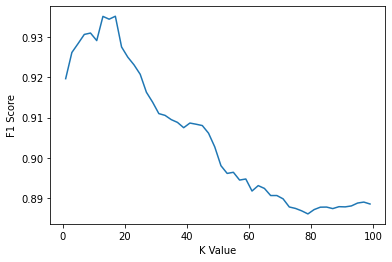

In [ ]:
# use 5-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
print('Finding the best k...')

#set variables and make empty lists
best_f1 = 0
best_k = -1

F1Scores = []
k_vals = []

#for loop for odd nums between 1 and 100
for i in range(1,100, 2):
  k_vals.append(i)
  clf = KNeighborsClassifier(n_neighbors= i)
  f1 = cross_val_score(clf, X, y, scoring = 'f1').mean()
  F1Scores.append(f1)
  #check if f1 score is higher than best score and if so replace score and k value
  if f1 > best_f1:
    best_f1 = f1
    best_k = i

print("Best K Value:", best_k, "with F1 Score:", best_f1)

plt.plot(k_vals, F1Scores)
plt.xlabel("K Value")
plt.ylabel("F1 Score")

Investigating depths...
The best depth limit is: 12


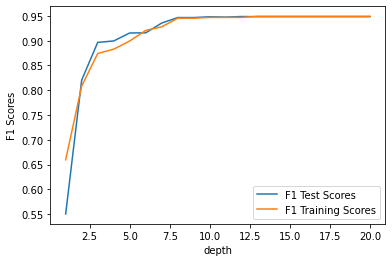

In [ ]:
# investigate decision tree classifier with various depths
print('Investigating depths...')

#set variables and make empty lists
best_f1 = 0
best_depth = -1

depth = []
F1_Training_Scores = []
F1_Scores = []


for i in range(1,21):
  depth.append(i)
  #create decision tree with each depth from 1 to 20
  clf = DecisionTreeClassifier(criterion='entropy', max_depth = i)
  #find cross validation scores for 20 fold
  f1 = cross_val_score(clf, X, y, scoring = 'f1', cv = 20).mean()
  F1_Scores.append(f1)
  #use error function to find training F1 scores
  F1_train = error(clf, X, y, ntrials = 1, test_size = 0.15)[2]
  F1_Training_Scores.append(F1_train)
  #if f1 score is greater than best f1 score replace f1 and the current depth
  if f1 > best_f1:
    best_f1 = f1
    best_depth = i
print("The best depth limit is:", best_depth)

plt.plot(depth, F1_Scores, label ="F1 Test Scores")
plt.plot(depth, F1_Training_Scores, label ="F1 Training Scores")
plt.xlabel("depth")
plt.ylabel("F1 Scores")
plt.legend()
